In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
from matplotlib.widgets import Cursor

from pathlib import Path
import sys

import xarray as xr
import os as os
import glob
import matplotlib.gridspec as gridspec
import metpy.calc as mpcalc
from metpy.units import units
import pickle

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import metpy
from metpy import constants

data_dir = '/work/wicker/MPAS_WRF_W/mpas_20240507'

proj = ccrs.LambertConformal(central_longitude=-85.0, central_latitude=45.0)

files = ['MPASSIT_01.2024-05-07_19.05.00.nc', 
         'MPASSIT_01.2024-05-07_19.10.00.nc', 
         'MPASSIT_01.2024-05-07_19.15.00.nc',
         'MPASSIT_01.2024-05-07_19.20.00.nc',
         'MPASSIT_01.2024-05-07_19.25.00.nc',
         'MPASSIT_01.2024-05-07_19.30.00.nc',
        ]


In [2]:
Rgas  = constants.dry_air_gas_constant.magnitude
Cpd   = constants.dry_air_spec_heat_press.magnitude
Cvd   = constants.dry_air_spec_heat_vol.magnitude
kappa = constants.poisson_exponent.magnitude
p00   = constants.pot_temp_ref_press.magnitude*100
print(Rgas, kappa, Cpd, Cvd)

287.04749097718457 0.28571428571428564 1004.6662184201462 717.6187274429616


In [3]:
prior = xr.open_dataset(os.path.join(data_dir, "wofs_vert_01.restart.2024-05-07_19.00.00_quad.nc"))
analy = xr.open_dataset(os.path.join(data_dir, "wofs_vert_01.analy_quad.nc"))


In [4]:
prior_refl = np.squeeze(prior['refl10cm'].values, 0).max(axis=0)
analy_refl = np.squeeze(analy['refl10cm'].values, 0).max(axis=0)


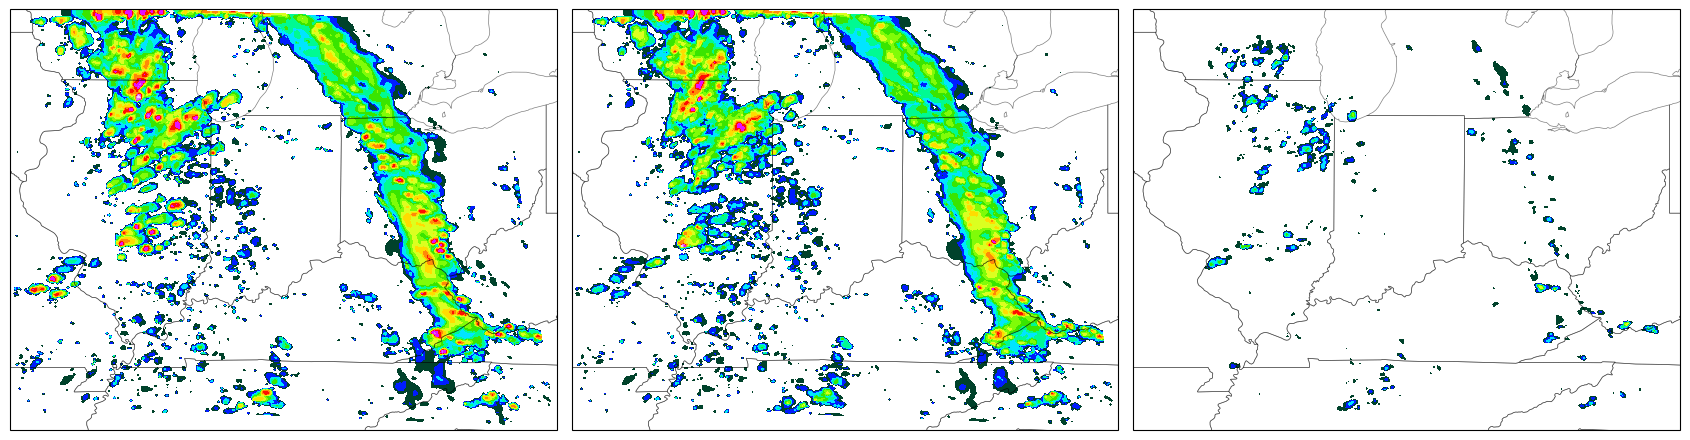

In [5]:

fig, axs = plt.subplots(1, 3, tight_layout=True, figsize=(17,5), subplot_kw={'projection': ccrs.PlateCarree()})

axs[0].contourf(prior.lon, prior.lat, prior_refl,cmap='gist_ncar',levels=np.arange(5,75,5), transform=ccrs.PlateCarree())
axs[0].add_feature(cfeature.STATES, linewidth=0.5, alpha=0.5)

axs[1].contourf(prior.lon, prior.lat, analy_refl,cmap='gist_ncar',levels=np.arange(5,75,5), transform=ccrs.PlateCarree())
axs[1].add_feature(cfeature.STATES, linewidth=0.5, alpha=0.5)
axs[2].contourf(prior.lon, prior.lat, analy_refl-prior_refl,cmap='gist_ncar',levels=np.arange(5,75,5), transform=ccrs.PlateCarree())
axs[2].add_feature(cfeature.STATES, linewidth=0.5, alpha=0.5);

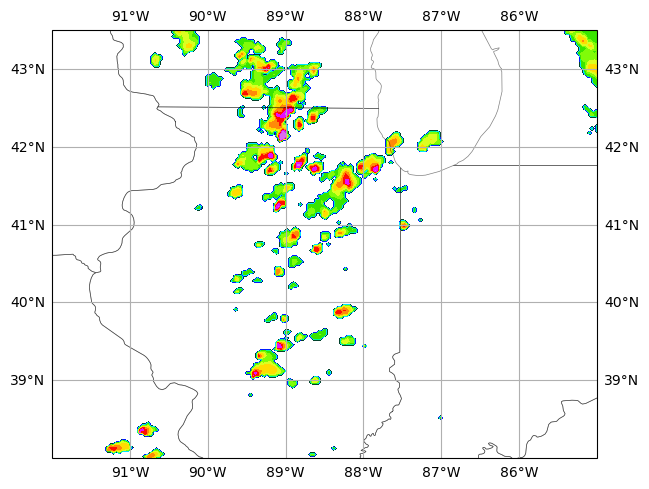

In [4]:
fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(17,5), subplot_kw={'projection': ccrs.PlateCarree()})

data_refl = np.squeeze(prior['refl10cm'].values, 0)[10]
data_refl = np.where(data_refl > 25, data_refl, 0.0)
axs.contourf(prior.lon, prior.lat, data_refl,cmap='gist_ncar', levels=np.arange(5,75,5), transform=ccrs.PlateCarree())
axs.add_feature(cfeature.STATES, linewidth=0.5, alpha=0.5)
axs.gridlines(draw_labels=True)
axs.set_ylim(38., 43.5)
axs.set_xlim(-92, -85)

selected_point, = axs.plot([], [], 'ro', markersize=8)

# Enable cursor tracking
cursor = Cursor(axs, useblit=True, color='red', linewidth=1)

selected_coords = {"x" : 0, "y" : 0}

def on_click(event):
    if event.xdata is not None and event.ydata is not None:
        x_idx = event.xdata
        y_idx = event.ydata
        print(f"Selected point: x={x_idx}, y={y_idx}")
        selected_point.set_data(x_idx, y_idx)
        fig.canvas.draw_idle()
        selected_coords['x'] = x_idx
        selected_coords['y'] = y_idx

fig.canvas.mpl_connect('button_press_event', on_click)
plt.show()

In [14]:
selected_coords

{'x': -87.47631048576532, 'y': 40.97697026125479}

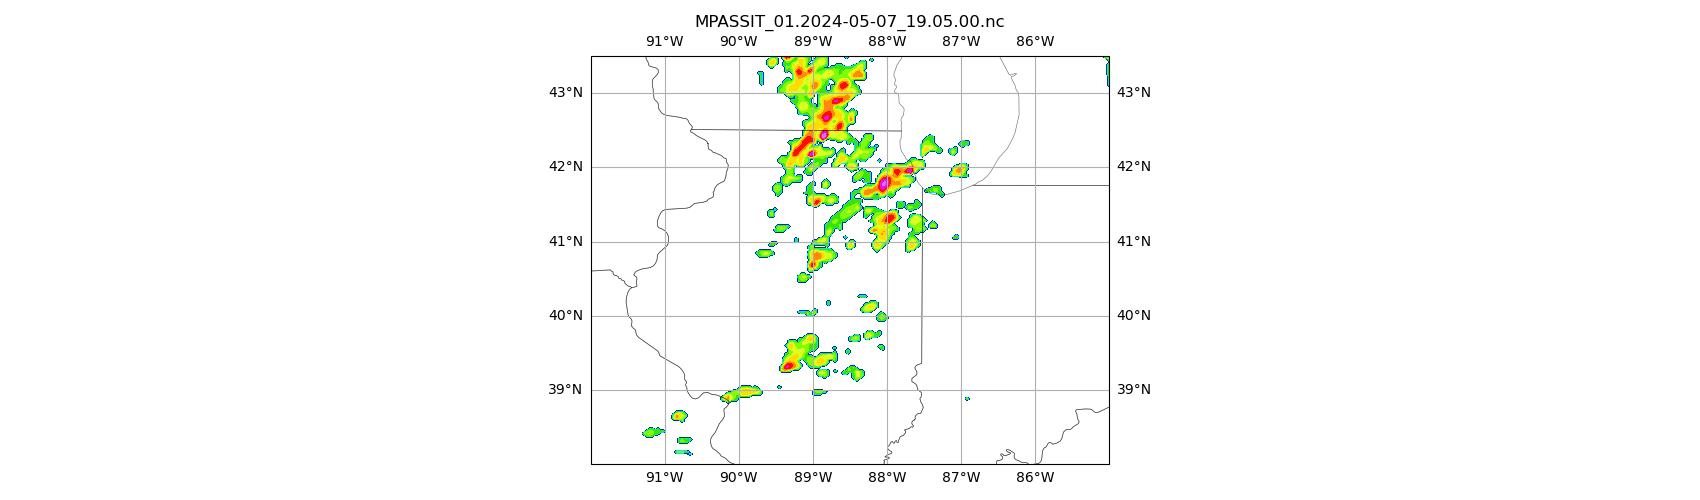

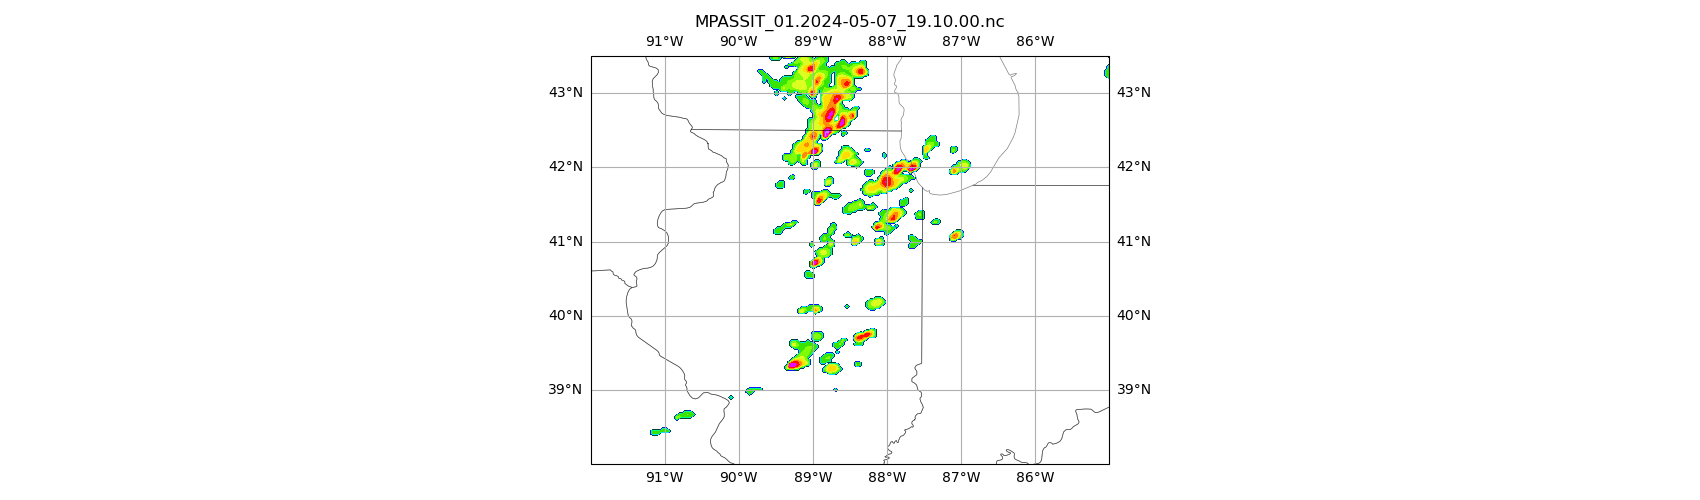

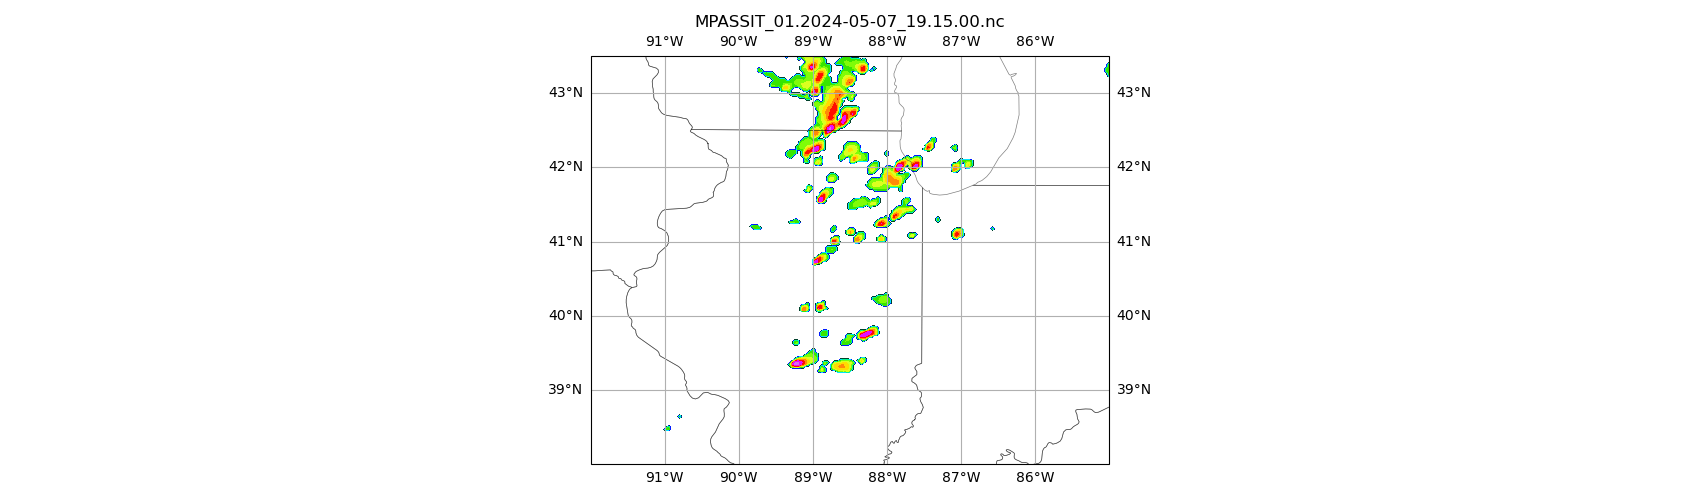

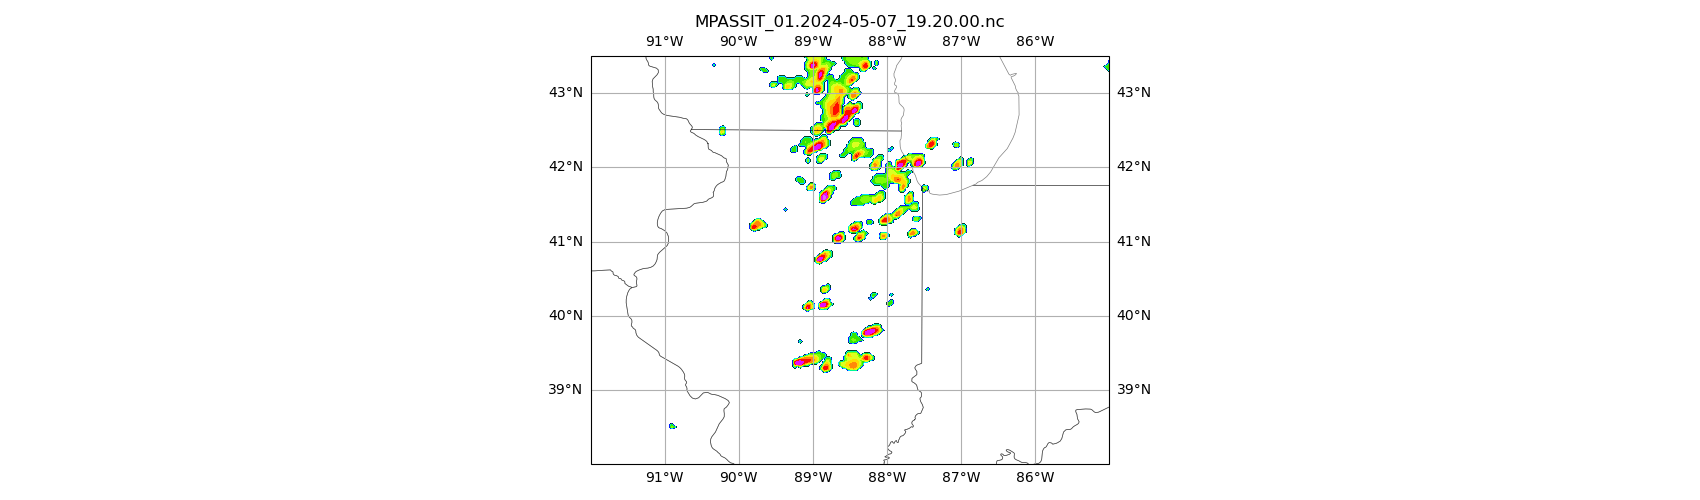

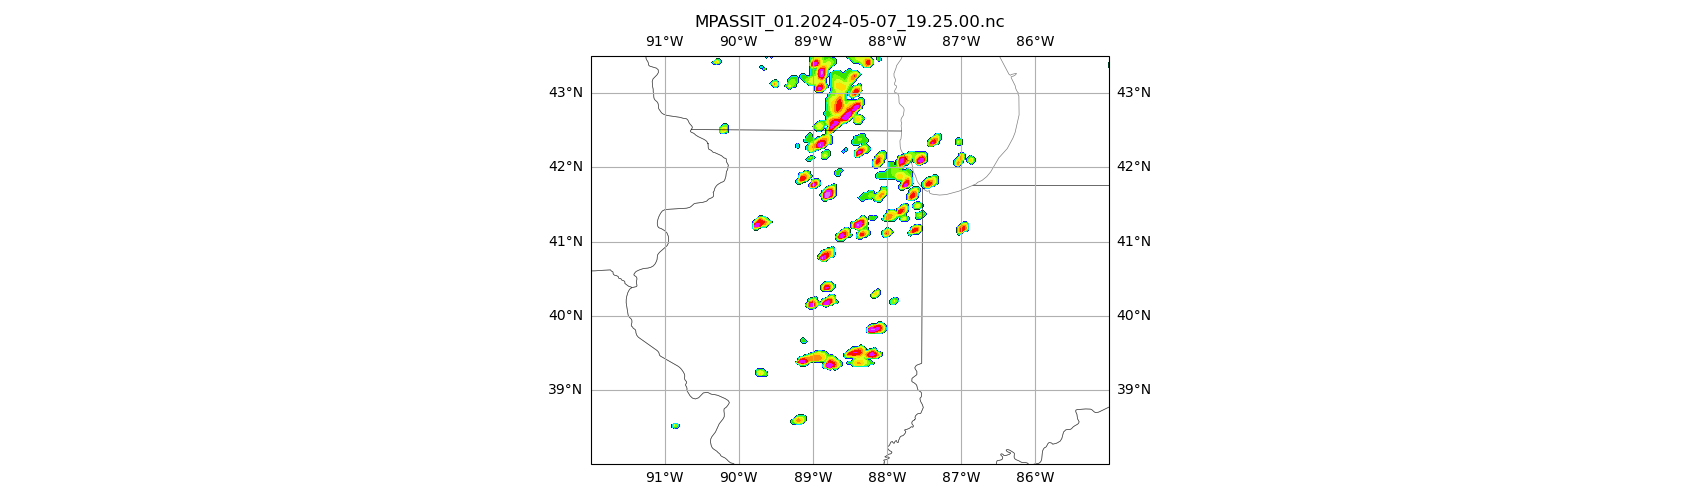

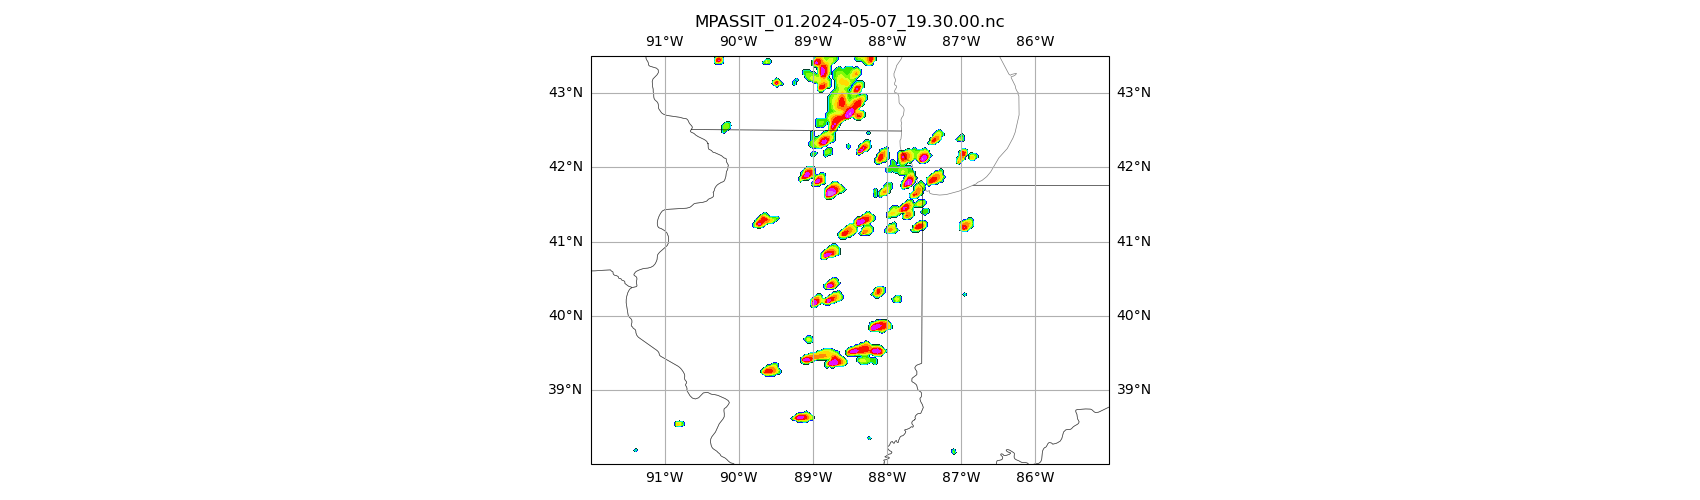

In [8]:
for file in files:
    data = xr.open_dataset(os.path.join(data_dir, file))
    data_refl = np.squeeze(data['REFL_10CM'].values, 0)[10]
    data_refl = np.where(data_refl > 25, data_refl, 0.0)
    fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(17,5), subplot_kw={'projection': ccrs.PlateCarree()})

    axs.contourf(prior.lon, prior.lat, data_refl,cmap='gist_ncar',levels=np.arange(5,75,5), transform=ccrs.PlateCarree())
    axs.add_feature(cfeature.STATES, linewidth=0.5, alpha=0.5)
    axs.gridlines(draw_labels=True)
    axs.set_ylim(38., 43.5)
    axs.set_xlim(-92, -85)

    plt.title(file)
    data.close()
    fig.canvas.mpl_connect('button_press_event', onclick)


In [56]:
def compute_pii(theta, rho, qv):
    return np.squeeze(((Rgas/p00) * rho * theta * (1.0 + 0.61*qv)) ** (Rgas/Cvd))
    
def compute_pres(theta, rho, qv):
    pii = (((Rgas/p00) * rho * theta * (1.0 + 0.61*qv)) ** (Rgas/Cvd))
    return np.squeeze(p00 * (pii ** (1.0/kappa)))
    
prior_pres = compute_pres(prior['theta'].values, prior['rho'].values, prior['qv'].values)
analy_pres = compute_pres(analy['theta'].values, analy['rho'].values, analy['qv'].values)
prior_pii = compute_pii(prior['theta'].values, prior['rho'].values, prior['qv'].values)
analy_pii = compute_pii(analy['theta'].values, analy['rho'].values, analy['qv'].values)
prior_temp = prior['theta'].values * prior_pii
analy_temp = analy['theta'].values * analy_pii

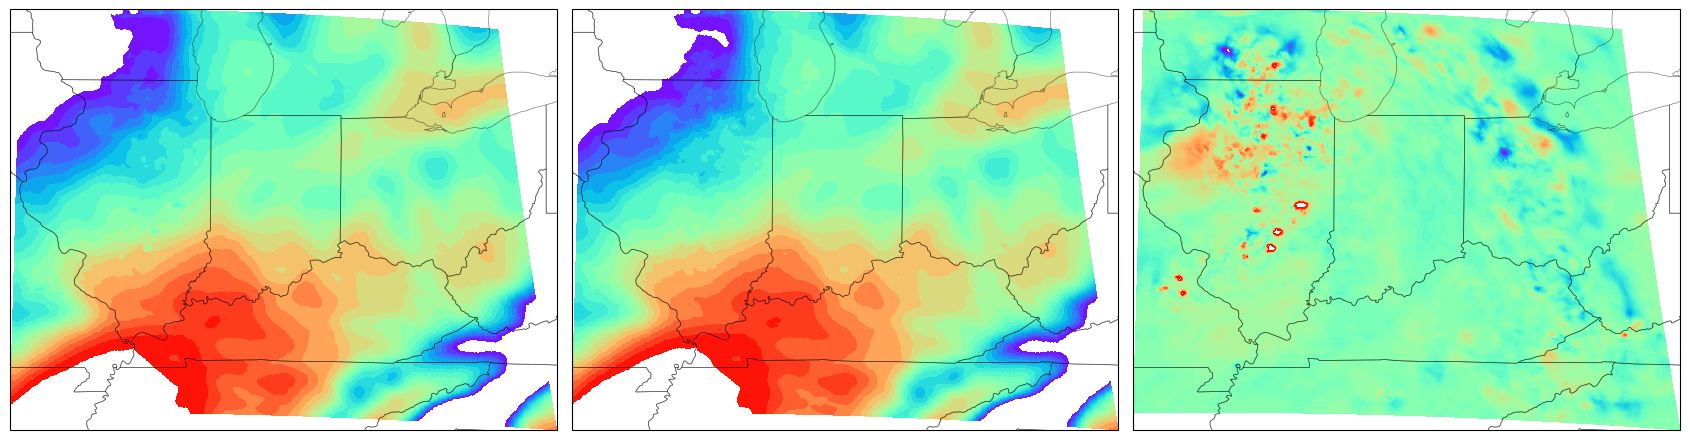

In [9]:
fig, axs = plt.subplots(1, 3, tight_layout=True, figsize=(17,5), subplot_kw={'projection': ccrs.PlateCarree()})

klevel = 20
pmean  = analy_pres[klevel].mean()

axs[0].contourf(prior.lon, prior.lat, prior_pres[klevel]-pmean,cmap='rainbow',levels=np.arange(-1000,1100,100), transform=ccrs.PlateCarree())
axs[0].add_feature(cfeature.STATES, linewidth=0.5, alpha=0.5)

axs[1].contourf(prior.lon, prior.lat, analy_pres[klevel]-pmean,cmap='rainbow',levels=np.arange(-1000,1100,100), transform=ccrs.PlateCarree())
axs[1].add_feature(cfeature.STATES, linewidth=0.5, alpha=0.5)
axs[2].contourf(prior.lon, prior.lat, (analy_pres-prior_pres)[klevel],cmap='rainbow',levels=np.arange(-100,105,5), transform=ccrs.PlateCarree())
axs[2].add_feature(cfeature.STATES, linewidth=0.5, alpha=0.5);

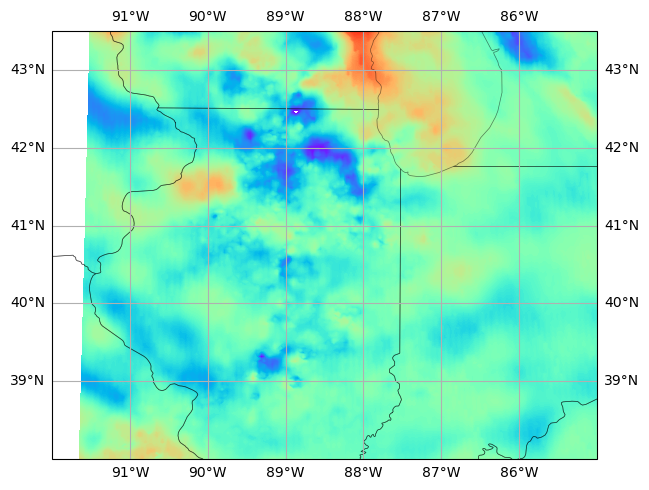

In [12]:
data = xr.open_dataset(os.path.join(data_dir, files[0]))
data_pres = np.squeeze(data['P'].values + data['PB'])[klevel]
fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(17,5), subplot_kw={'projection': ccrs.PlateCarree()})

axs.contourf(prior.lon, prior.lat, (analy_pres[klevel]-data_pres),cmap='rainbow',levels=np.arange(-300,300,5), transform=ccrs.PlateCarree())
axs.add_feature(cfeature.STATES, linewidth=0.5, alpha=0.5)
axs.gridlines(draw_labels=True)
axs.set_ylim(38., 43.5)
axs.set_xlim(-92, -85)

data.close()

In [33]:
from metpy.calc import relative_humidity_from_mixing_ratio, saturation_mixing_ratio

from metpy.units import units

prior_rh = np.squeeze(prior['qv'].values) / np.squeeze(saturation_mixing_ratio(prior_pres * units.hPa, (prior_temp-273.16) * units.degC))

analy_rh = np.squeeze(analy['qv'].values) / np.squeeze(saturation_mixing_ratio(analy_pres * units.hPa, (analy_temp-273.16) * units.degC))

print(prior_rh.max())
print(analy_rh.max())


156.20750427246094 dimensionless
153.55722045898438 dimensionless


Text(0.5, 1.0, 'Anal-Prior')

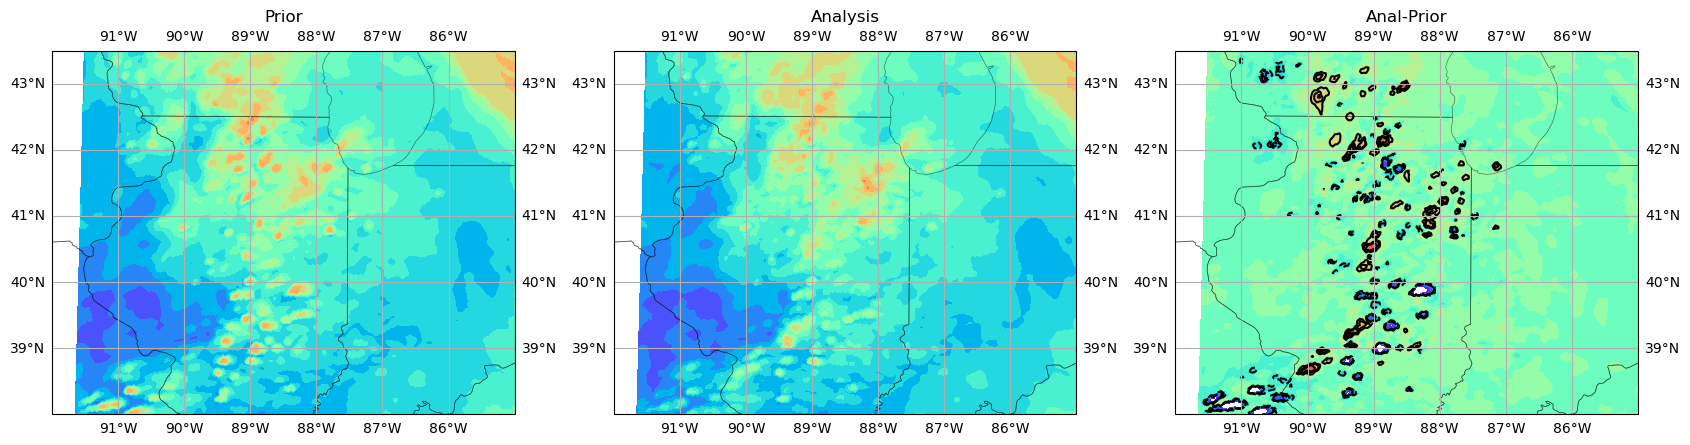

In [104]:
fig, axs = plt.subplots(1, 3, tight_layout=True, figsize=(17,5), subplot_kw={'projection': ccrs.PlateCarree()})
from mpl_toolkits.axes_grid1 import make_axes_locatable

k1 = 10
k2 = 20

axs[0].contourf(prior.lon, prior.lat, prior_rh[k1:k2].mean(axis=0), cmap='rainbow',levels=np.arange(0,150,10), transform=ccrs.PlateCarree())
axs[0].add_feature(cfeature.STATES, linewidth=0.5, alpha=0.5)
axs[0].gridlines(draw_labels=True)
axs[0].set_ylim(38., 43.5)
axs[0].set_xlim(-92, -85)
axs[0].set_title('Prior')

axs[1].contourf(prior.lon, prior.lat, analy_rh[k1:k2].mean(axis=0), cmap='rainbow',levels=np.arange(0,150,10), transform=ccrs.PlateCarree())
axs[1].add_feature(cfeature.STATES, linewidth=0.5, alpha=0.5)
axs[1].gridlines(draw_labels=True)
axs[1].set_ylim(38., 43.5)
axs[1].set_xlim(-92, -85)
axs[1].set_title('Analysis')

diff = axs[2].contourf(prior.lon, prior.lat, (analy_rh-prior_rh)[k1:k2].mean(axis=0), cmap='rainbow',levels=np.arange(-35,40,5), transform=ccrs.PlateCarree())
axs[2].contour(prior.lon, prior.lat, (analy_rh-prior_rh)[k1:k2].mean(axis=0), colors='k',levels=[-20,-15,-10,10,15,20], transform=ccrs.PlateCarree())
axs[2].add_feature(cfeature.STATES, linewidth=0.5, alpha=0.5);

axs[2].gridlines(draw_labels=True)
axs[2].set_ylim(38., 43.5)
axs[2].set_xlim(-92, -85)
axs[2].set_title('Anal-Prior')

# divider = make_axes_locatable(axs[2])
# cax = divider.append_axes('right', size='5%', pad=0.05, axes_class=axs[2])
# fig.colorbar(diff, cax=axs[2], orientation='vertical')


Text(0, 0.5, 'Z (km)')

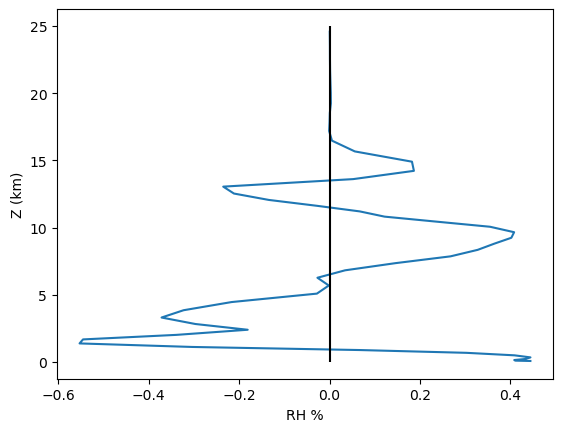

In [105]:
plt.plot((analy_rh-prior_rh).mean(axis=(1,2)), prior['z']*0.001)
plt.vlines(0.0, ymin=0.0, ymax=25, color='k')
plt.xlabel('RH %')
plt.ylabel('Z (km)')


Text(0.5, 1.0, 'Anal-Prior')

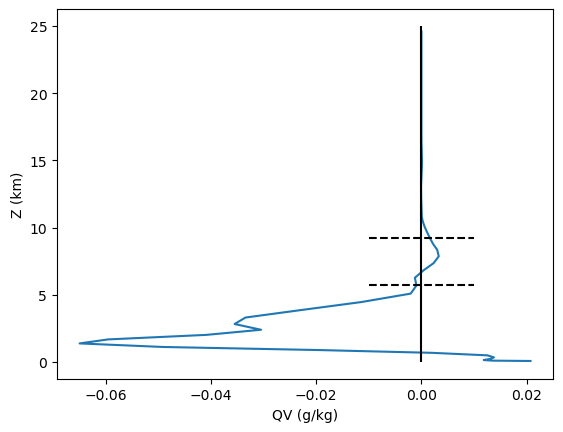

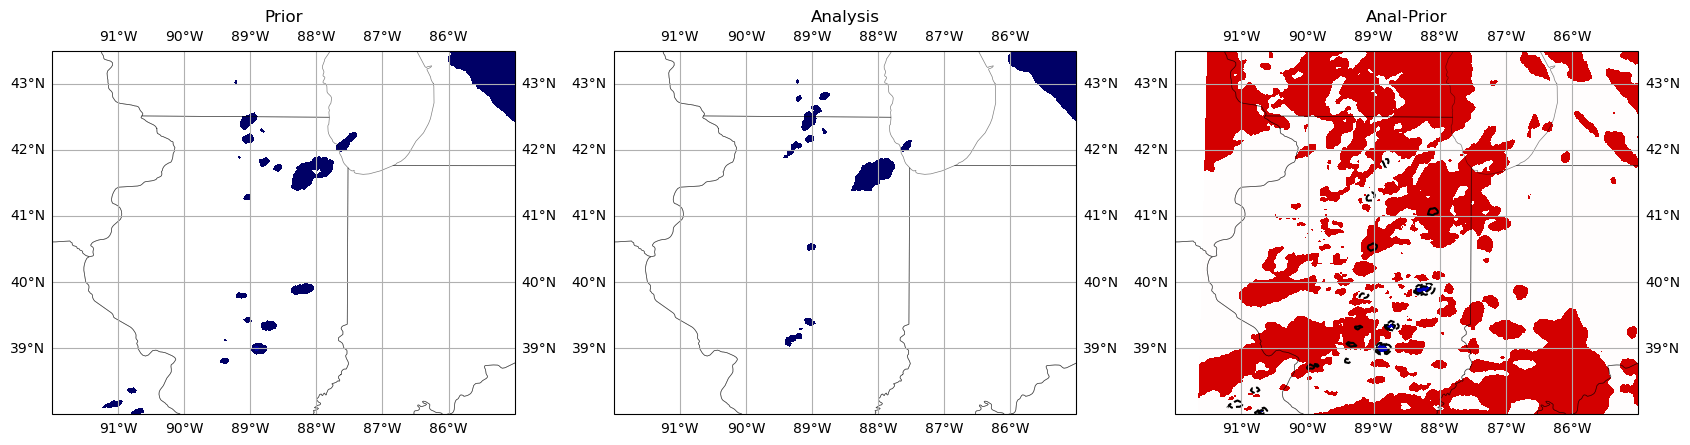

In [114]:
prior_qv = 1000*np.squeeze(prior['qv'].values)
analy_qv = 1000*np.squeeze(analy['qv'].values)

k1 = 18
k2 = 25


plt.plot((analy_qv-prior_qv).mean(axis=(1,2)), prior['z']*0.001)
plt.vlines(0.0, ymin=0.0, ymax=25, color='k')
plt.hlines(prior['z'][k1]*0.001, xmin=-0.01, xmax=0.01, color='k', linestyle='--')
plt.hlines(prior['z'][k2]*0.001, xmin=-0.01, xmax=0.01, color='k', linestyle='--')
plt.xlabel('QV (g/kg)')
plt.ylabel('Z (km)')
           
fig, axs = plt.subplots(1, 3, tight_layout=True, figsize=(17,5), sharey=True, subplot_kw={'projection': ccrs.PlateCarree()})
from mpl_toolkits.axes_grid1 import make_axes_locatable


axs[0].contourf(prior.lon, prior.lat, prior_qv[k1:k2].mean(axis=0), cmap='seismic', levels=np.arange(1,15,1), transform=ccrs.PlateCarree())
axs[0].add_feature(cfeature.STATES, linewidth=0.5, alpha=0.5)
axs[0].gridlines(draw_labels=True)
axs[0].set_ylim(38., 43.5)
axs[0].set_xlim(-92, -85)
axs[0].set_title('Prior')

axs[1].contourf(prior.lon, prior.lat, analy_qv[k1:k2].mean(axis=0), cmap='seismic', levels=np.arange(1,15,1), transform=ccrs.PlateCarree())
axs[1].add_feature(cfeature.STATES, linewidth=0.5, alpha=0.5)
axs[1].gridlines(draw_labels=True)
axs[1].set_ylim(38., 43.5)
axs[1].set_xlim(-92, -85)
axs[1].set_title('Analysis')

diff = axs[2].contourf(prior.lon, prior.lat, (analy_qv-prior_qv)[k1:k2].mean(axis=0), cmap='seismic',levels=np.arange(-2,2,1), transform=ccrs.PlateCarree())
diff = axs[2].contour(prior.lon, prior.lat, (analy_qv-prior_qv)[k1:k2].mean(axis=0), levels=[-1.0, -0.5, 0.5, 1.0], colors='k', transform=ccrs.PlateCarree())
axs[2].add_feature(cfeature.STATES, linewidth=0.5, alpha=0.5);

axs[2].gridlines(draw_labels=True)
axs[2].set_ylim(38., 43.5)
axs[2].set_xlim(-92, -85)
axs[2].set_title('Anal-Prior')
